In [51]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
import tflscripts
import json
import pickle

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results_filtered.p')

In [52]:
without_transfer = df.loc[df.type_of_transfer == 'No transfer']
df_transfer = df.loc[df.type_of_transfer != 'No transfer']

def apply_accuracy_without_transfer(x):
    queried = without_transfer.query('source_device_name == "{}" & source_dataset == "{}" & features == "{}" & label == "{}" & classifier == "{}"'.format(
        x['source_device_name'],
        x['source_dataset'],
        x['features'],
        x['label'],
        x['classifier']
    ))

    if len(queried) > 0:
        return queried['accuracy'].iloc[0], \
            queried['accuracy_positive'].iloc[0], \
            queried['accuracy_negative'].iloc[0],

    return -1

df_transfer['accuracy_wt'], df_transfer['accuracy_positive_wt'], df_transfer['accuracy_negative_wt'] = \
zip(*df_transfer.apply(apply_accuracy_without_transfer, axis=1))

/home/giotto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
def device_name(name):
    return ' '.join(name.split(' ')[0:2])


df_transfer['devices'] = [device_name(row['source_device_name']) + '->' + device_name(row['target_device_name']) for i, row in df_transfer.iterrows()]
df_transfer['target_device'] = [device_name(row['target_device_name']) for i, row in df_transfer.iterrows()]
df_transfer['source_device'] = [device_name(row['source_device_name']) for i, row in df_transfer.iterrows()]
df_transfer['replica'] = ['Replica' if row['source_device'] == row['target_device'] else 'Not replica' for i, row in df_transfer.iterrows()]
df_transfer['samples_r'] = np.round(df_transfer.samples.values / 10) * 10

/home/giotto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/giotto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/giotto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

In [54]:
df_transfer['accuracy_change'] = df_transfer['accuracy'] - df_transfer['accuracy_wt']
df_transfer['accuracy_positive_change'] = df_transfer['accuracy_positive'] - df_transfer['accuracy_positive_wt']
df_transfer['accuracy_negative_change'] = df_transfer['accuracy_negative'] - df_transfer['accuracy_negative_wt']

/home/giotto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/giotto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/giotto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [55]:
import seaborn as sns

def plot_by(column, label='Microwave', features='Microphone', classifier='LogisticRegression',
            x_value_column='accuracy_negative', y_value_column='accuracy_negative_wt', common_limits=True):

    df_plot = df_transfer
    if label is not None:
        df_plot = df_plot.loc[df_plot.label == label]
    df_plot = df_plot.loc[df_plot.features_name == features]
    df_plot = df_plot.loc[df_plot.classifier == classifier]

    fig, ax = plt.subplots()

    for value in df_plot[column].drop_duplicates():
        subdf_plot = df_plot.loc[df_plot[column] == value]
        if len(subdf_plot) > 0:
            ax.scatter(subdf_plot[x_value_column], subdf_plot[y_value_column], label=value)
    ax.legend()

    min_val = min(df_plot[x_value_column].min(), df_plot[y_value_column].min()) - 0.02
    max_val = max(df_plot[x_value_column].max(), df_plot[y_value_column].max()) + 0.02

    if common_limits:
        ax.set_ylim(min_val, max_val)
        ax.set_xlim(min_val, max_val)

    plt.title(column)
    plt.xlabel(x_value_column)
    plt.ylabel(y_value_column)
    plt.show()


def boxplot_by(column, label='Microwave', features='Microphone', classifier='LogisticRegression',
            value_column='accuracy_positive_change'):
    df_plot = df_transfer
    if label is not None:
        df_plot = df_plot.loc[df_plot.label == label]
    df_plot = df_plot.loc[df_plot.features_name == features]
    df_plot = df_plot.loc[df_plot.classifier == classifier]

    newdf = pd.DataFrame()

    for device in df_plot[column].unique():
        subdf = df_plot.loc[df_plot[column] == device]
        newdf[device] = subdf[value_column].reset_index(drop=True)

    newdf = newdf.sort_index(axis=1)
    newdf.plot.box()
    plt.title(column)
    plt.xticks(rotation='vertical')
    plt.show()

def heatmap_by(x_column, y_column, value_column,
               label=None, features='Microphone', classifier='LogisticRegression',
               common_limits=True):

    title_parts = []
    
    df_plot = df_transfer
    if label is not None:
        df_plot = df_plot.loc[df_plot.label == label]
        title_parts.append(label)
    if features is not None:
        df_plot = df_plot.loc[df_plot.features_name == features]
        title_parts.append(features)
    if classifier is not None:
        df_plot = df_plot.loc[df_plot.classifier == classifier]
        title_parts.append(classifier)
        

    df_plot = df_plot.groupby([x_column, y_column])[value_column].mean()
    df_plot = df_plot.reset_index()
    df_plot = df_plot.pivot(index=y_column, columns=x_column, values=value_column)
    sns.heatmap(df_plot, annot=True)
    plt.title(', '.join(title_parts))
    plt.show()

0.978787878788


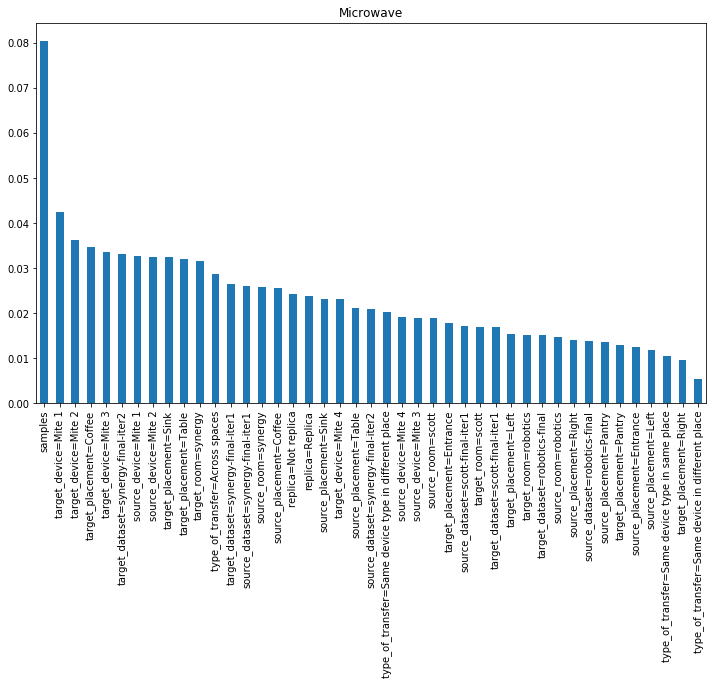

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score

label = 'Microwave'
features = 'All'
value_column = 'accuracy_positive_change'

df_plot = df_transfer
df_plot = df_plot.loc[df_plot.label == label]
df_plot = df_plot.loc[df_plot.features_name == features]
df_plot = df_plot.loc[df_plot.classifier == 'LogisticRegression']
df_plot['y'] = np.round(df_plot[value_column] * 10)
X_columns = [
    'source_dataset', 'target_dataset',
    'source_device', 'target_device',
    'type_of_transfer',
    'source_room', 'target_room',
    'source_placement', 'target_placement',
#     'accuracy_wt', 'accuracy_positive_wt', 'accuracy_negative_wt',
    'replica', 'samples'
]
X = df_plot[X_columns]
vect = DictVectorizer()

X = [dict(r.iteritems()) for _, r in X.iterrows()]
X = vect.fit_transform(X)
X = pd.DataFrame(X.toarray())
X.columns = vect.feature_names_

all_importances = []
accuracies = []

for i in range(50):
    rf = RandomForestClassifier()
    rf.fit(X.values, df_plot['y'].values)
    importances = pd.Series(rf.feature_importances_)
    all_importances.append(importances)
    accuracies.append(accuracy_score(df_plot['y'].values, rf.predict(X.values)))

importances = pd.DataFrame(all_importances).mean()
importances.index = X.columns
importances = importances.sort_values(ascending=False)
importances.plot.bar()
plt.title(label)
print(np.mean(accuracies))

0.95202020202


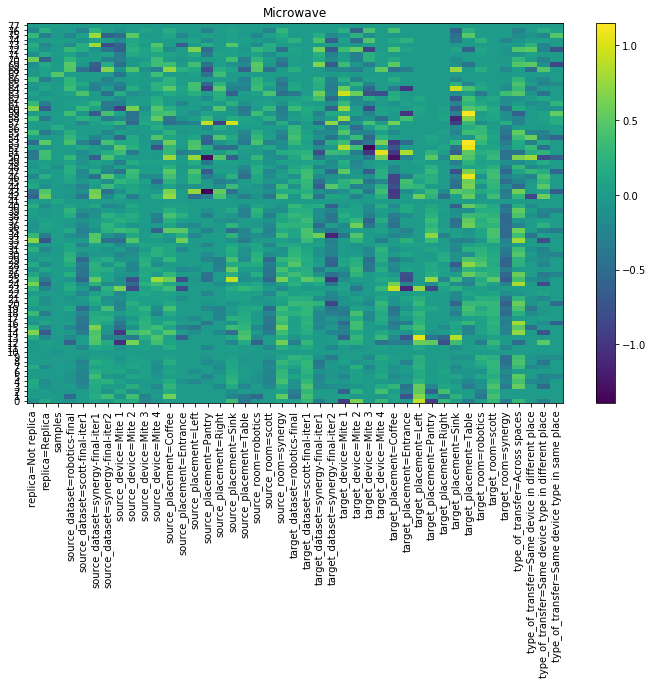

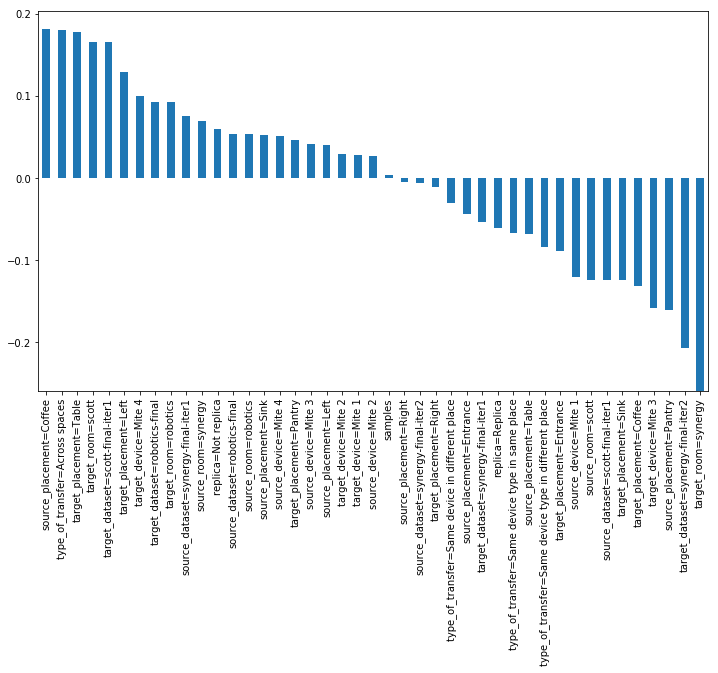

In [57]:
from sklearn.svm import SVC

all_coefficients = None
num_coefficients = 0
for i in range(10):
    clf = SVC(kernel='linear')
    clf.fit(X.values, df_plot['y'].values)
    if all_coefficients is None:
        all_coefficients = clf.coef_.copy()
    else:
        all_coefficients += clf.coef_.copy()
    num_coefficients += 1
    accuracies.append(accuracy_score(df_plot['y'].values, clf.predict(X.values)))

all_coefficients = all_coefficients / num_coefficients

weights = pd.DataFrame(all_coefficients)
weights.columns = X.columns
# weights.index = np.sort(df_plot['y'].unique())
plt.pcolor(weights)
plt.yticks(np.arange(0.5, len(weights.index), 1), weights.index)
plt.xticks(np.arange(0.5, len(weights.columns), 1), weights.columns, rotation='vertical')
plt.colorbar()
plt.title(label)
print(np.mean(accuracies))
plt.show()
weights.mean().sort_values(ascending=False).plot.bar()

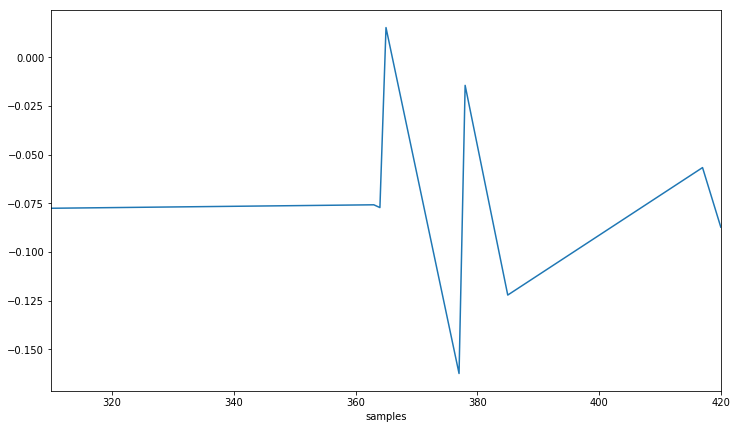

In [58]:
df_plot = df_transfer
df_plot = df_plot.loc[df_plot.label == 'Dishes']
df_plot = df_plot.loc[df_plot.features_name == 'Microphone']
df_plot = df_plot.loc[df_plot.classifier == 'SVM']
df_plot = df_plot[['samples', 'accuracy_change']]
df_plot.groupby(['samples'])['accuracy_change'].mean().plot()

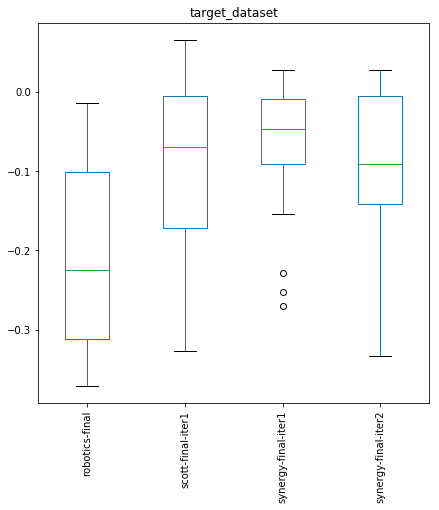

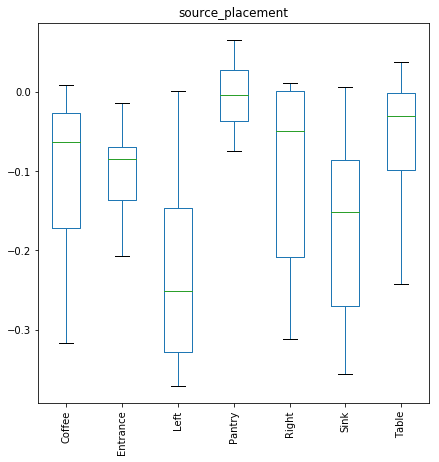

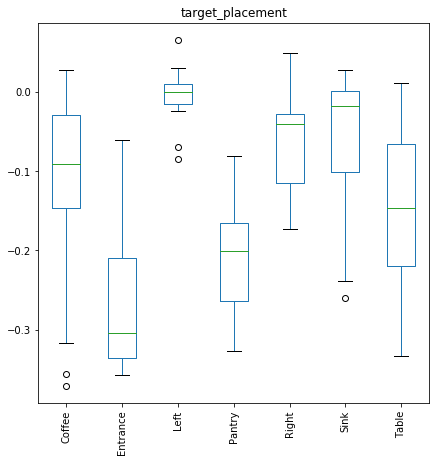

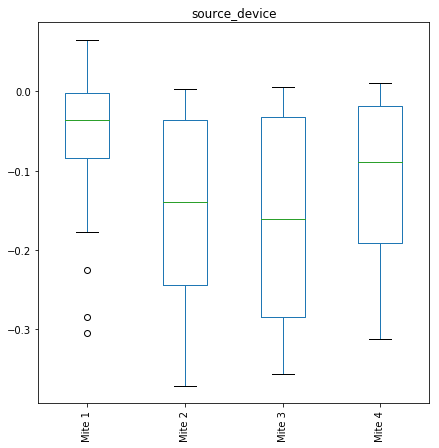

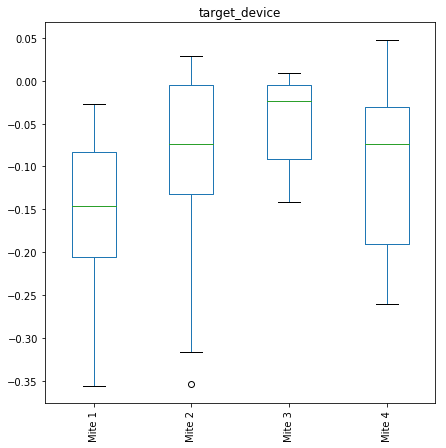

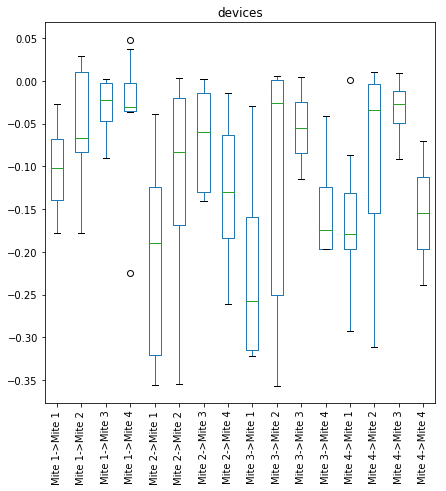

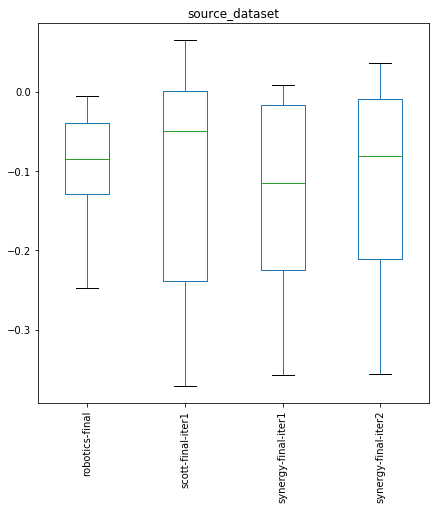

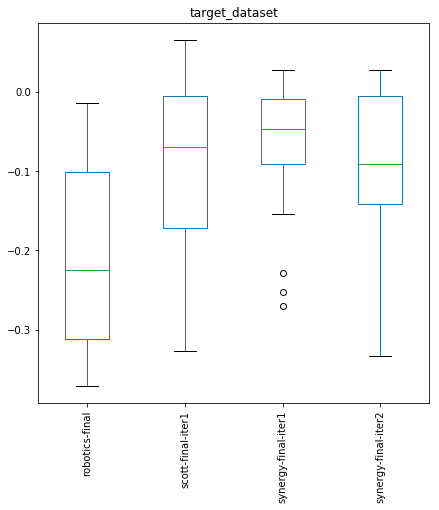

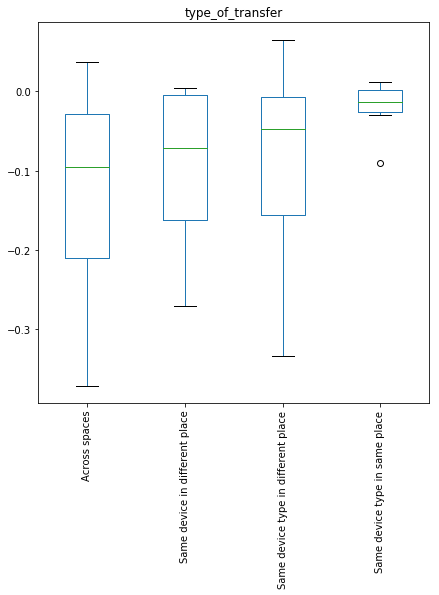

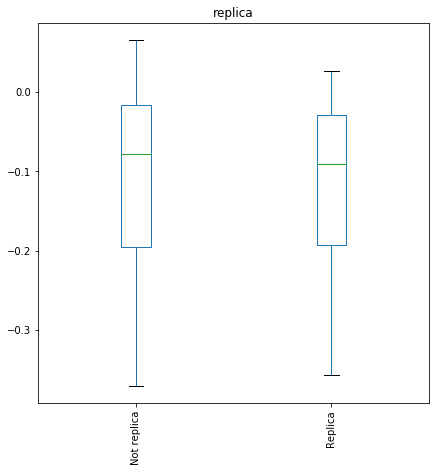

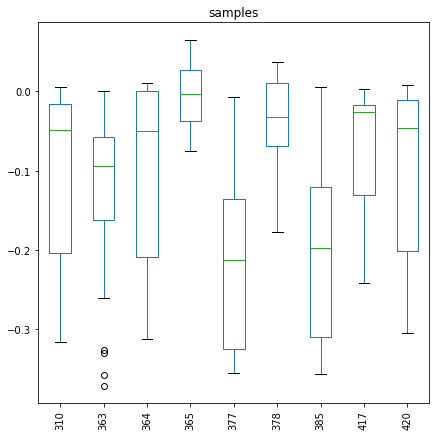

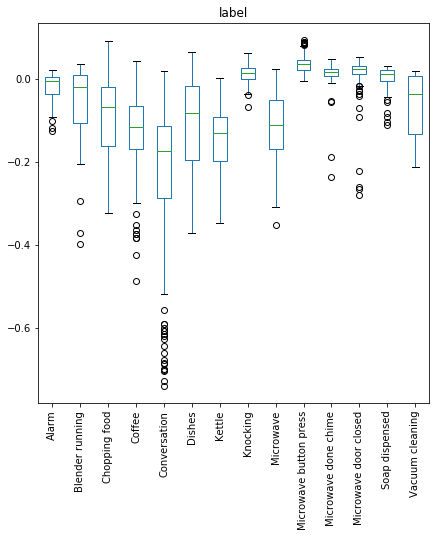

In [62]:
plt.rcParams["figure.figsize"] = (7, 7)

features = 'All'
label = 'Dishes'
value_column = 'accuracy_change'

boxplot_by('target_dataset', value_column=value_column, label=label, features=features)
boxplot_by('source_placement', value_column=value_column, label=label, features=features)
boxplot_by('target_placement', value_column=value_column, label=label, features=features)
boxplot_by('source_device', value_column=value_column, label=label, features=features)
boxplot_by('target_device', value_column=value_column, label=label, features=features)
boxplot_by('devices', value_column=value_column, label=label, features=features)
boxplot_by('source_dataset', value_column=value_column, label=label, features=features)
boxplot_by('target_dataset', value_column=value_column, label=label, features=features)
boxplot_by('type_of_transfer', value_column=value_column, label=label, features=features)
boxplot_by('replica', value_column=value_column, label=label, features=features)
boxplot_by('samples', value_column=value_column, label=label, features=features)
boxplot_by('label', value_column=value_column, label=None, features=features)

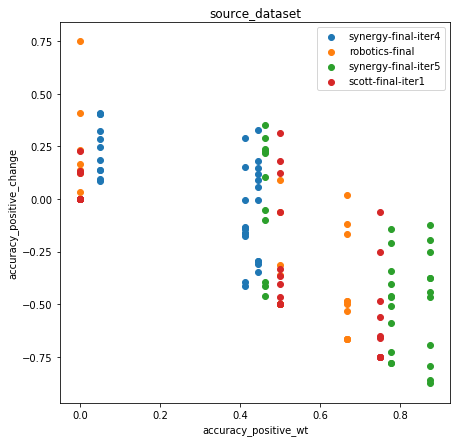

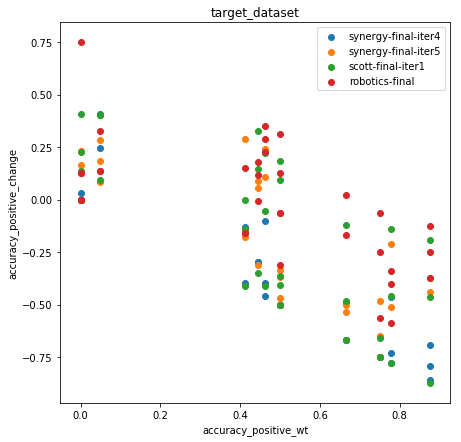

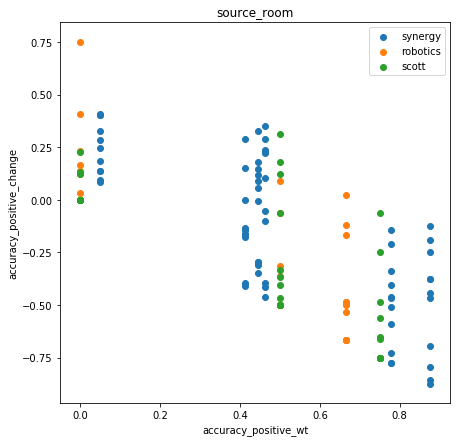

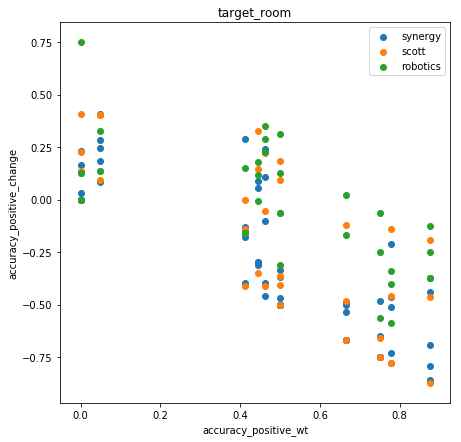

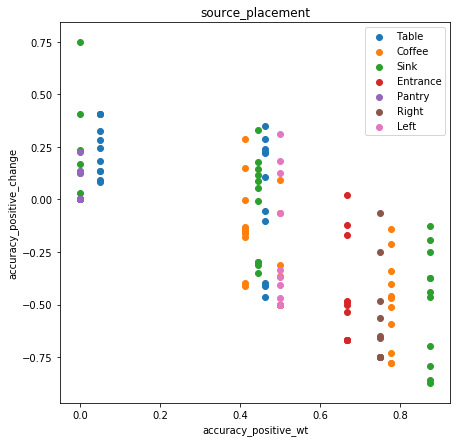

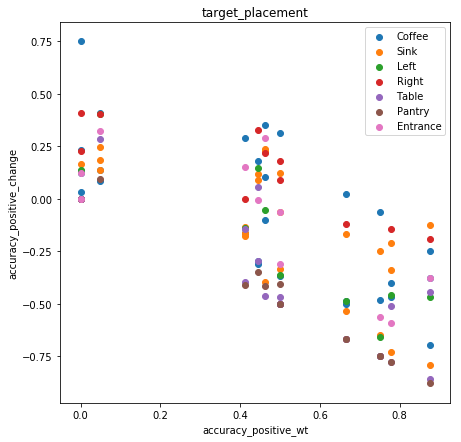

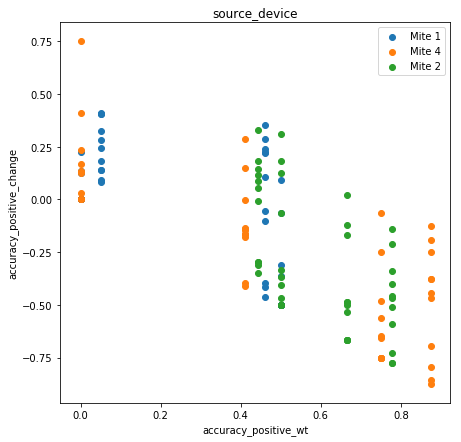

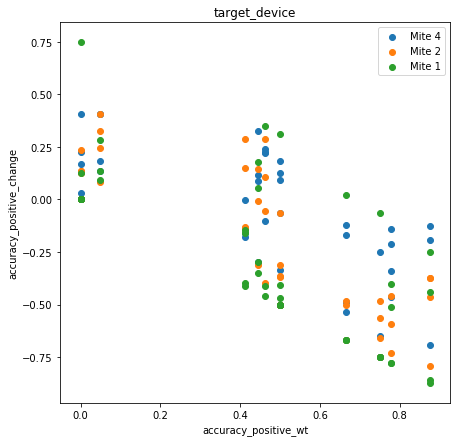

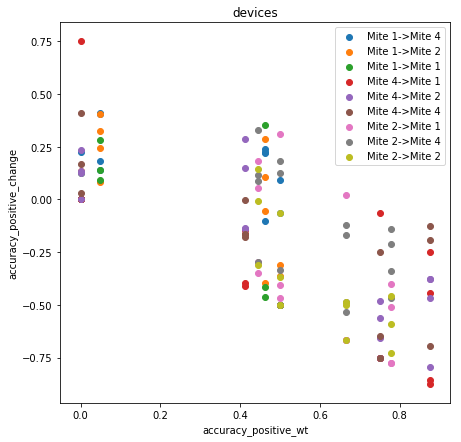

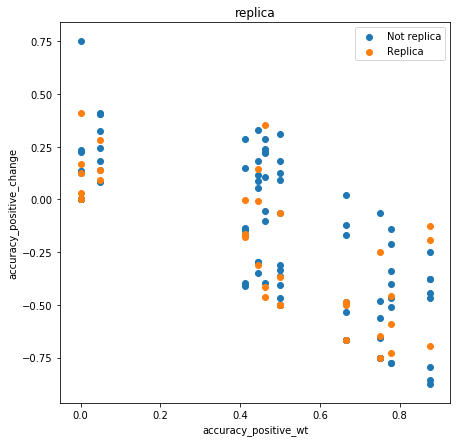

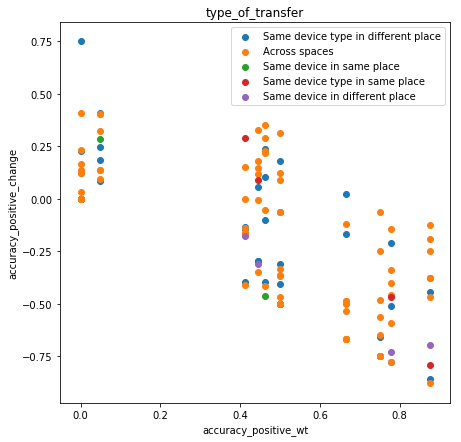

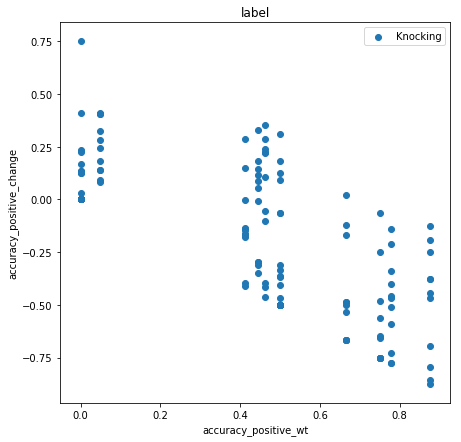

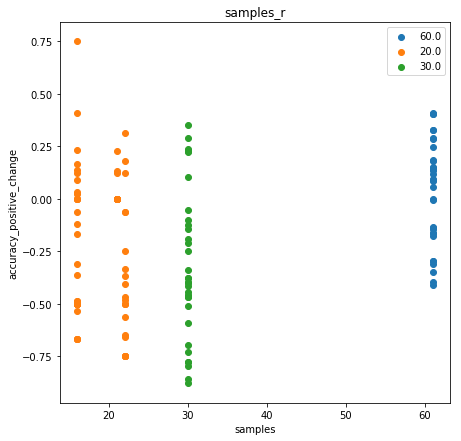

In [60]:
x_value_column = 'accuracy_positive_wt'
y_value_column = 'accuracy_positive_change'
label='Knocking'
features='Microphone'

plot_by('source_dataset', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('target_dataset', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('source_room', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('target_room', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('source_placement', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('target_placement', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('source_device', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('target_device', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('devices', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('replica', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('type_of_transfer', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('label', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('samples_r', x_value_column='samples', y_value_column=y_value_column, common_limits=False, label=label, features=features)

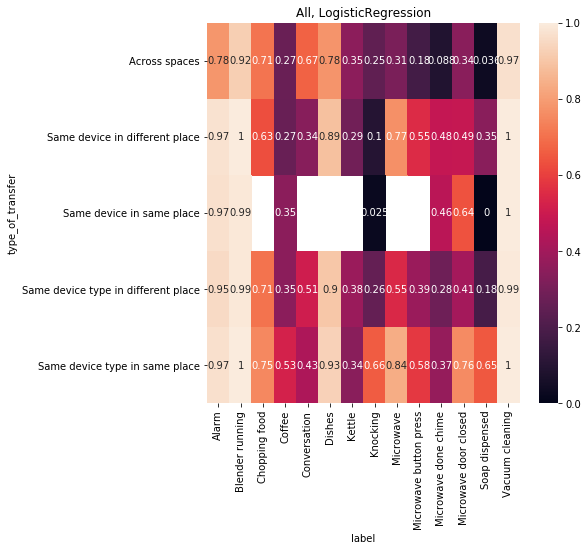

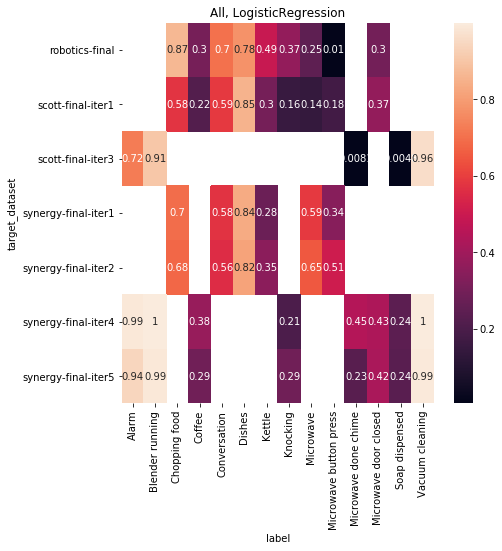

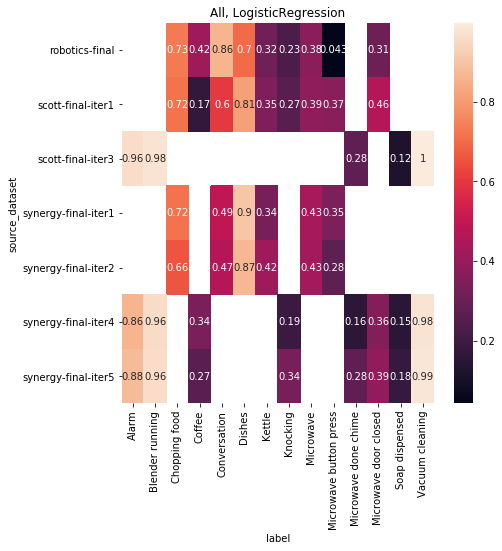

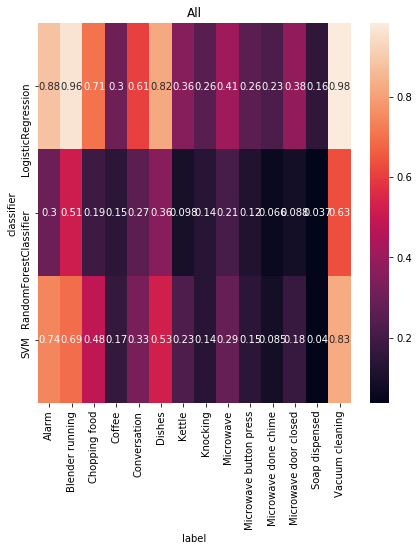

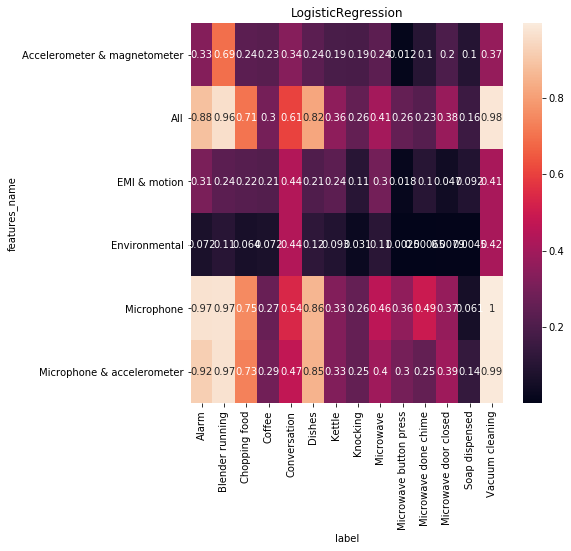

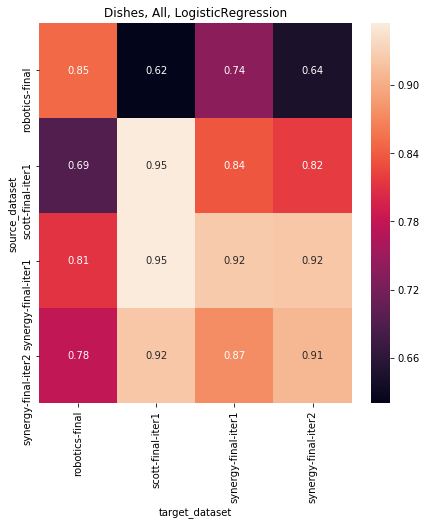

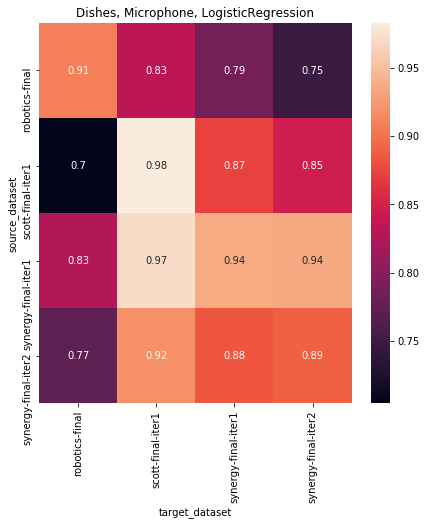

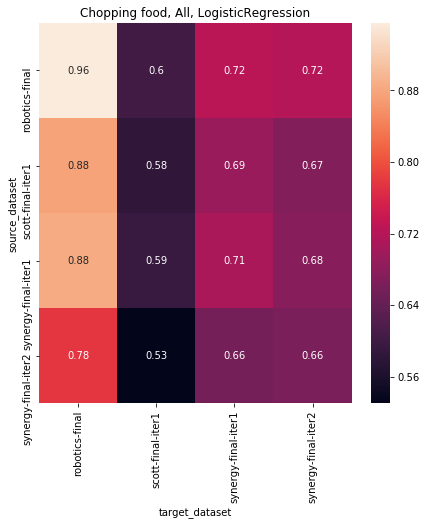

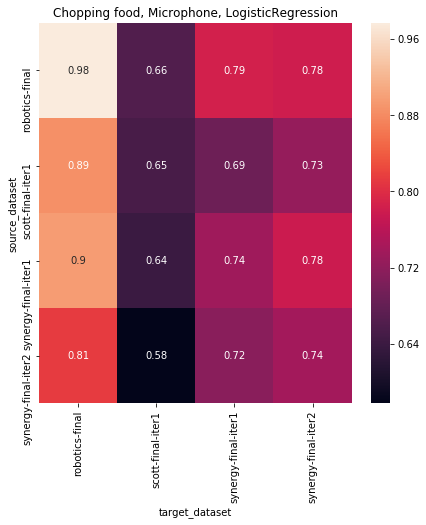

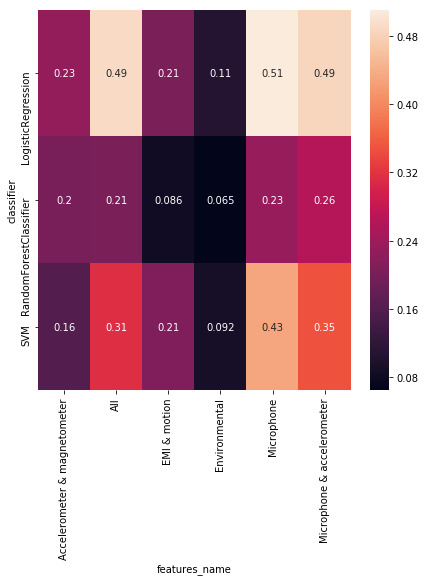

In [61]:
value_column = 'accuracy_positive'
heatmap_by('label', 'type_of_transfer', value_column, label=None, features='All', classifier='LogisticRegression')
heatmap_by('label', 'target_dataset', value_column, label=None, features='All', classifier='LogisticRegression')
heatmap_by('label', 'source_dataset', value_column, label=None, features='All', classifier='LogisticRegression')
heatmap_by('label', 'classifier', value_column, label=None, features='All', classifier=None)
heatmap_by('label', 'features_name', value_column, label=None, features=None, classifier='LogisticRegression')
heatmap_by('target_dataset', 'source_dataset', value_column, label='Dishes', features='All', classifier='LogisticRegression')
heatmap_by('target_dataset', 'source_dataset', value_column, label='Dishes', features='Microphone', classifier='LogisticRegression')
heatmap_by('target_dataset', 'source_dataset', value_column, label='Chopping food', features='All', classifier='LogisticRegression')
heatmap_by('target_dataset', 'source_dataset', value_column, label='Chopping food', features='Microphone', classifier='LogisticRegression')
heatmap_by('features_name', 'classifier', value_column, label=None, features=None, classifier=None)

In [35]:
df_transfer

,source_dataset,target_dataset,source_device,target_device,source_device_name,target_device_name,source_room,target_room,source_placement,target_placement,...,accuracy_negative,accuracy_wt,accuracy_positive_wt,accuracy_negative_wt,devices,replica,samples_r,accuracy_change,accuracy_positive_change,accuracy_negative_change
1,scott-final-iter1,synergy-final-iter1,Mite 4,Mite 3,Mite 4 Right,Mite 3 Sink,scott,synergy,Right,Sink,...,0.934135,0.969212,0.830645,0.994186,Mite 4->Mite 3,Not replica,370.0,-0.110403,-0.459929,-0.060051
2,scott-final-iter1,synergy-final-iter1,Mite 4,Mite 2,Mite 4 Right,Mite 2 Table,scott,synergy,Right,Table,...,0.961621,0.969212,0.830645,0.994186,Mite 4->Mite 2,Not replica,370.0,-0.084814,-0.492231,-0.032565
3,scott-final-iter1,synergy-final-iter2,Mite 4,Mite 2,Mite 4 Right,Mite 2 Sink,scott,synergy,Right,Sink,...,0.968393,0.969212,0.830645,0.994186,Mite 4->Mite 2,Not replica,370.0,-0.052356,-0.232819,-0.025793
4,scott-final-iter1,synergy-final-iter2,Mite 4,Mite 3,Mite 4 Right,Mite 3 Coffee,scott,synergy,Right,Coffee,...,0.983671,0.969212,0.830645,0.994186,Mite 4->Mite 3,Not replica,370.0,-0.080060,-0.442585,-0.010515
5,scott-final-iter1,synergy-final-iter4,Mite 4,Mite 1,Mite 4 Right,Mite 1 Table,scott,synergy,Right,Table,...,0.915366,0.969212,0.830645,0.994186,Mite 4->Mite 1,Not replica,370.0,-0.147800,-0.724005,-0.078820
6,scott-final-iter1,synergy-final-iter4,Mite 4,Mite 4,Mite 4 Right,Mite 4 Coffee,scott,synergy,Right,Coffee,...,0.961603,0.969212,0.830645,0.994186,Mite 4->Mite 4,Replica,370.0,-0.095551,-0.516533,-0.032583
7,scott-final-iter1,synergy-final-iter5,Mite 4,Mite 2,Mite 4 Right,Mite 2 Coffee,scott,synergy,Right,Coffee,...,0.899032,0.969212,0.830645,0.994186,Mite 4->Mite 2,Not replica,370.0,-0.118020,-0.368703,-0.095154
8,scott-final-iter1,synergy-final-iter5,Mite 4,Mite 4,Mite 4 Right,Mite 4 Sink,scott,synergy,Right,Sink,...,0.859973,0.969212,0.830645,0.994186,Mite 4->Mite 4,Replica,370.0,-0.182267,-0.604923,-0.134213
9,scott-final-iter1,scott-final-iter1,Mite 4,Mite 2,Mite 4 Right,Mite 2 Left,scott,scott,Right,Left,...,0.793977,0.969212,0.830645,0.994186,Mite 4->Mite 2,Not replica,370.0,-0.159785,0.066374,-0.200209
10,scott-final-iter1,robotics-final,Mite 4,Mite 1,Mite 4 Right,Mite 1 Coffee,scott,robotics,Right,Coffee,...,0.965194,0.969212,0.830645,0.994186,Mite 4->Mite 1,Not replica,370.0,-0.122000,-0.684757,-0.028992
